# HEART RATE ESTIMATION

Ballistocardiography(BCG) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed). 

In [1]:
######  LIBRARIES  #######
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft, ifft
from scipy.signal import welch, butter, filtfilt, find_peaks
import pywt

**Data preparation:**

1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

In [2]:
###### IMPORT DATA #######
file_name = "3_Subject_sitting_chair.txt"

# creation of a DataFrame containing the whole dataset
df_chair = pd.DataFrame(pd.read_csv(file_name, sep = "\t", header = 0))

# select just the column of interest
df_chair = df_chair.iloc[:,[1,3,4,5,6,7,8]]

# recover the samples frequency
freq = df_chair['Log Freq'][0]

# create the time vector
time = np.arange(0, len(df_chair)* 1/freq, 1/freq)

# create the AccX, AccY, AccZ ,GyroX, GyroY, GyroZ vectors
accX, accY, accZ = df_chair['AccX'][:], df_chair['AccY'][:], df_chair['AccZ'][:]
gyroX,gyroY,gyroZ = df_chair['GyroX'][:], df_chair['GyroY'][:], df_chair['GyroZ'][:]

# insert time column
df_chair.insert(1, "Time", time)

# print data
df_chair.head()


,Log Freq,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,100,0.00,-32.940,132.309,1385.676,2.926829,-9.024390,-6.463415
1,100,0.01,139.080,-31.659,1044.259,1.341463,1.341463,0.365854
2,100,0.02,15.311,-33.184,1025.227,-3.902439,0.975610,0.365854
3,100,0.03,13.847,-35.807,1017.480,-4.024390,1.219512,0.243902
4,100,0.04,8.052,-35.258,1018.456,-2.560976,1.829268,0.121951


2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

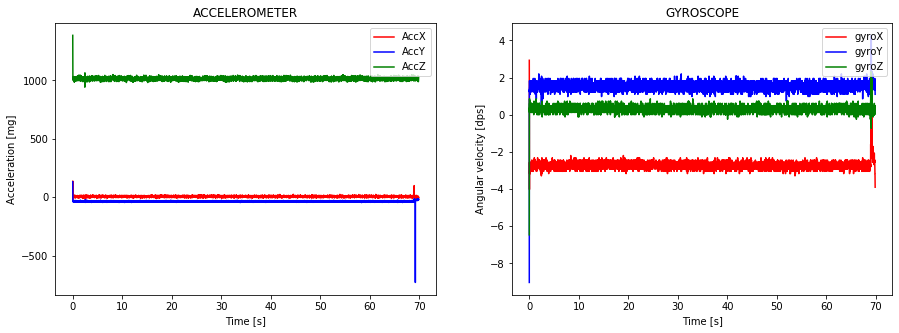

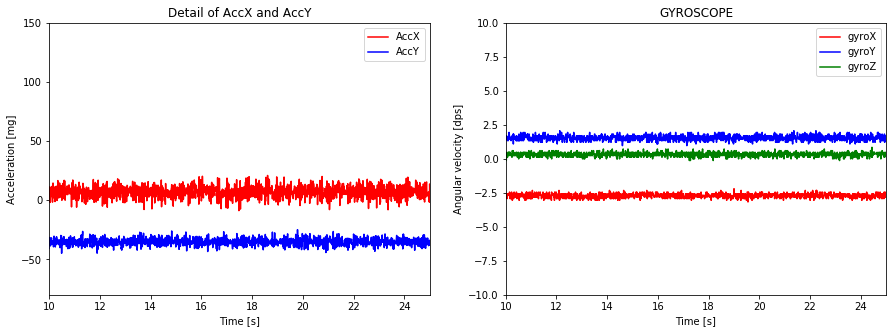

In [3]:
##### PLOT OF THE DATA #####

# create the subplots 
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot the accelerometer's data
axis[0].plot(time,accX,'r',label = 'AccX')
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].plot(time,accZ,'g',label = 'AccZ')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('ACCELEROMETER')
axis[0].legend(loc = 1)

#plot the gyroscope's data
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('GYROSCOPE')
axis[1].legend(loc = 1)

# create the subplots for a detail of the previous ones
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot a detail of the accelerometer plot
axis[0].plot(time,accX,'r',label = 'AccX')
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('Detail of AccX and AccY')
axis[0].set_ylim([-80,150])
axis[0].set_xlim([10,25])
axis[0].legend(loc = 1)

# plot a detail of the gyroscope plot
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('GYROSCOPE')
axis[1].set_ylim([-10,10])
axis[1].set_xlim([10,25])
axis[1].legend(loc = 1)

plt.show()

3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  

In [4]:
# select interval of interest to avoid the large amount of noise at the beginning and at the end of the original
# signal
df_chair = df_chair[(df_chair['Time'] >= 5) & (df_chair['Time'] < 65)]

# update accX, accY, accZ, gyroX, gyroY, gyroZ according to the new interval of interest
time = np.arange(0, len(df_chair)* 1/freq, 1/freq)
accX, accY, accZ = df_chair['AccX'][:], df_chair['AccY'][:], df_chair['AccZ'][:]
gyroX, gyroY, gyroZ = df_chair['GyroX'][:], df_chair['GyroY'][:], df_chair['GyroZ'][:]


**PCA for Accelerometer**

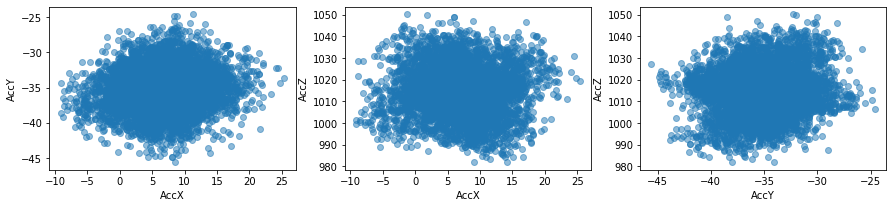

In [5]:
# create the matrix for the PCA technique, in the rows there are the AccX, AccY, AccZ measurments, and each 
# column represents a data sample
X_acc = np.array([accX, accY, accZ])

figure, axis = plt.subplots(1,3, figsize = (15,3))
axis[0].scatter(X_acc[0,:], X_acc[1,:], alpha=0.5)
axis[0].set_xlabel('AccX')
axis[0].set_ylabel('AccY')
axis[1].scatter(X_acc[0,:], X_acc[2,:], alpha=0.5)
axis[1].set_xlabel('AccX')
axis[1].set_ylabel('AccZ')
axis[2].scatter(X_acc[1,:], X_acc[2,:], alpha=0.5)
axis[2].set_xlabel('AccY')
axis[2].set_ylabel('AccZ')
plt.show()

[[105.79   0.     0.  ]
 [  0.    24.49   0.  ]
 [  0.     0.     8.67]] 

Trace of the original data matrix:  138.95
Trace of the data matrix after the changes of base:  138.95 

Fraction of the total variability keeping only the first principal component:  76.0 %
Fraction of the total variability keeping only the first two principal components:  94.0 %
Fraction of the total variability keeping only the last two principal components:  24.0 %


/home/giovanni/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


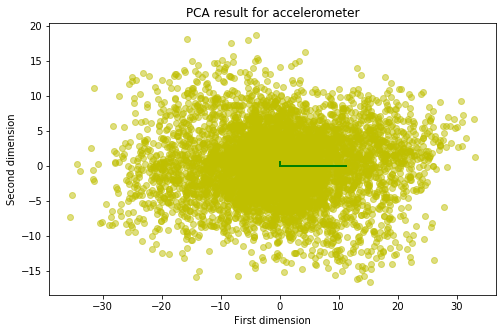

In [6]:
# compute the mean of X and subtract it to obtain a zero main matrix X
X_acc = X_acc - X_acc.mean()

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covarinace matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_acc))
#P = V.T
#Cy = P.dot(np.cov(X_acc)).dot(P.T)
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")


# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_acc).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first two principal components: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the last two principal components: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")

# as consequence of the PCA technique keeping the two principal components for the Accelerometer is better

P = V[:,0:2] #the eigenvectors are in the columns of V

PCA_acc = P.T.dot(X_acc) # new data according to PCA result

#Visualize the original data projected into the new space with the relative principal axis
scale_factor = 0.001
first_dim = PCA_acc[0] - PCA_acc[0].mean()
second_dim = PCA_acc[1] - PCA_acc[1].mean()

plt.figure(figsize=(8,5))
plt.scatter(first_dim, second_dim, alpha=0.5, c = 'y')
plt.plot([0, scale_factor*l[0]*np.cov(PCA_acc)[0,0]], [0, scale_factor*l[0]*np.cov(PCA_acc)[1,0]], 'g', lw=2)
plt.plot([0, scale_factor*l[1]*np.cov(PCA_acc)[0,1]], [0, scale_factor*l[1]*np.cov(PCA_acc)[1,1]], 'g', lw=2)
plt.title('PCA result for accelerometer')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.show()

**PCA for Gyroscope**

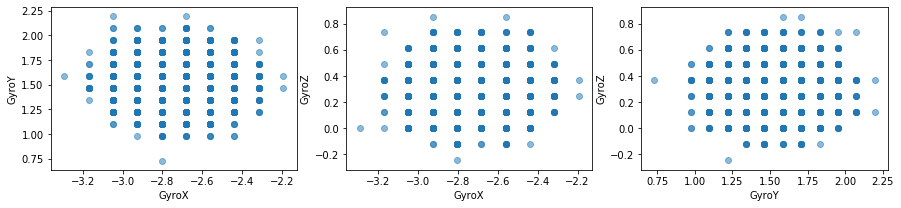

In [7]:
X_gyro = np.array([gyroX, gyroY, gyroZ]) 

figure, axis = plt.subplots(1,3, figsize = (15,3))
axis[0].scatter(X_gyro[0,:], X_gyro[1,:], alpha=0.5)
axis[0].set_xlabel('GyroX')
axis[0].set_ylabel('GyroY')
axis[1].scatter(X_gyro[0,:], X_gyro[2,:], alpha=0.5)
axis[1].set_xlabel('GyroX')
axis[1].set_ylabel('GyroZ')
axis[2].scatter(X_gyro[1,:], X_gyro[2,:], alpha=0.5)
axis[2].set_xlabel('GyroY')
axis[2].set_ylabel('GyroZ')
plt.show()

[[0.02 0.   0.  ]
 [0.   0.02 0.  ]
 [0.   0.   0.03]] 

Trace of the original data matrix:  0.08
Trace of the data matrix after the changes of base:  0.07 

Fraction of the total variability keeping only the first principal component:  29.0 %
Fraction of the total variability keeping only the first two principal components:  57.0 %
Fraction of the total variability keeping only the last two principal components:  71.0 %


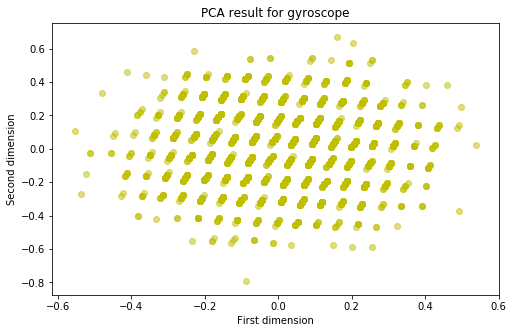

In [8]:
#compute the mean of X and subtract it to obtain a zero main matrix X
X_gyro = X_gyro - X_gyro.mean()

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covarinace matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_gyro))
#P = V.T
#Cy = P.dot(np.cov(X)).dot(P.T)
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")


# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_gyro).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first two principal components: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the last two principal components: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")


## ACCORDING TO PCA RESULTS IS BETTER TO KEEP THE DATA AS IT IS, AVOIDING SO TO PROJECT THE ORIGINAL DATA
## INTO A NEW BASE, WE WILL LOST SO MUCH INFORMATION.
## TODO: FIX THE PART BELOW ACCORDING TO THE COMMENT ABOVE

# as consequence of the PCA technique keeping the two principal components for the Gyroscope is better
P = V[:,1:3] #the eigenvectors are in the columns of V

PCA_gyro = P.T.dot(X_gyro) # new data according to PCA result


#Visualize the original data projected into the new space with the relative principal axis
first_dim = PCA_gyro[0] - PCA_gyro[0].mean()
second_dim = PCA_gyro[1] - PCA_gyro[1].mean()

plt.figure(figsize=(8,5))
plt.scatter(first_dim, second_dim, alpha=0.5, c = 'y')
plt.plot([0, l[1]*np.cov(PCA_gyro)[0,0]], [0, l[1]*np.cov(PCA_gyro)[1,0]], 'g', lw=2)
plt.plot([0, l[2]*np.cov(PCA_gyro)[0,1]], [0, l[2]*np.cov(PCA_gyro)[1,1]], 'g', lw=2)
plt.title('PCA result for gyroscope')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.show()

**Time and frequency analysis:**

1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 

**Filter:**
    
    Implement your own filter, trying to extrapolate heart rate signal. Hint:
    
    (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
    
    (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).
    
    (d) Find another method by yourselves.
    
 Motivate your choice.

**Metrics:**

1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution?
2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.

**Optional Algorithm:** 

Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).  